In [1]:
# Essential for python to interact with the operating system
import os
import re
# Model development framework
import torch
import torch.nn as nn
# Image processing functions
import torchvision
import torchvision.models as models
import PIL
from torch.utils.data import Dataset
from torch.utils.data import Subset, random_split
from torchvision.io import read_image
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from tkinter import Image
from PIL import Image
# Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
# Free up GPU memory
torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, 5)
model_ft = model_ft.to(device)

c:\Pytorch_for_fyp\envfyp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Pytorch_for_fyp\envfyp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
checkpoints = 'C:\\Pytorch_for_fyp\\envfyp\\Data\\checkpoints\\model_checkpoint_akn.pth'

In [5]:
transformation = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data_path = 'C:\\Pytorch_for_fyp\\envfyp\\Data\\resized_traintest15_train19\\'
csv_file = 'C:\\Pytorch_for_fyp\\envfyp\\Data\\labels\\traintestLabels15_trainLabels19.csv'
df = pd.read_csv(csv_file)
df['image'] = df['image'].apply(str)
df['level'] = df['level'].apply(int)
print(df)

              image  level
0           10_left      0
1          10_right      0
2           13_left      0
3          13_right      0
4           15_left      1
...             ...    ...
92359  ffa47f6a7bf4      2
92360  ffc04fed30e6      0
92361  ffcf7b45f213      2
92362  ffd97f8cd5aa      0
92363  ffec9a18a3ce      2

[92364 rows x 2 columns]


In [7]:
#  Dictionary to map image filenames to class labels
mapping = {}
for index, row in df.iterrows():
    filename = row['image']
    class_label = row['level']
    mapping[filename] = class_label

In [8]:
class DiaretDataset(Dataset):
    def __init__(self, mapping, root_dir, labels_df, transform=None):
        self.mapping = mapping
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = list(mapping.keys())
        self.labels_df = labels_df

    def __getitem__(self, index):
        filename = self.labels_df.iloc[index]['image']
        image_path = os.path.join(self.root_dir, filename)
        image_path += ".jpg"
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        class_label = self.mapping[filename]
        return image, class_label

    def __len__(self):
        return len(self.filenames)

In [9]:
full_dataset = DiaretDataset(mapping, data_path, df, transform=transformation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [10]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Training the model
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)

accumulation_steps = 4  # Number of batches to accumulate gradients

# Free up GPU memory
torch.cuda.empty_cache()

train_losses = []
train_accs = []  

# Training loop
total_step = len(train_dataloader)
model_ft.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, x in enumerate(train_dataloader):
        torch.cuda.empty_cache()
        images = x[0].to(device)
        labels = x[1].to(device)

        # Forward pass
        outputs = model_ft(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Calculate training loss and accuracy
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accs.append(train_accuracy)


torch.save(model_ft.state_dict(), checkpoints)
# Free up GPU memory
torch.cuda.empty_cache() 

Epoch [1/10], Step [10/2310], Loss: 0.7629
Epoch [1/10], Step [20/2310], Loss: 0.8807
Epoch [1/10], Step [30/2310], Loss: 0.9042
Epoch [1/10], Step [40/2310], Loss: 0.9029
Epoch [1/10], Step [50/2310], Loss: 0.9905
Epoch [1/10], Step [60/2310], Loss: 0.9388
Epoch [1/10], Step [70/2310], Loss: 1.1596
Epoch [1/10], Step [80/2310], Loss: 0.9301
Epoch [1/10], Step [90/2310], Loss: 0.8860
Epoch [1/10], Step [100/2310], Loss: 1.0166
Epoch [1/10], Step [110/2310], Loss: 0.8105
Epoch [1/10], Step [120/2310], Loss: 1.1445
Epoch [1/10], Step [130/2310], Loss: 1.3770
Epoch [1/10], Step [140/2310], Loss: 0.8469
Epoch [1/10], Step [150/2310], Loss: 0.6339
Epoch [1/10], Step [160/2310], Loss: 0.7741
Epoch [1/10], Step [170/2310], Loss: 0.9805
Epoch [1/10], Step [180/2310], Loss: 0.6853
Epoch [1/10], Step [190/2310], Loss: 0.5969
Epoch [1/10], Step [200/2310], Loss: 0.6866
Epoch [1/10], Step [210/2310], Loss: 0.6451
Epoch [1/10], Step [220/2310], Loss: 0.7957
Epoch [1/10], Step [230/2310], Loss: 0.95

In [12]:
# Free up GPU memory
torch.cuda.empty_cache()
# Load the fine-tuned model for evaluation
model_ft.load_state_dict(torch.load(checkpoints))

for epoch in range(num_epochs):
    val_losses = []
    val_accs = []  # Track validation accuracies
# Validation loop
    model_ft.eval()
    with torch.no_grad():
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        
        for x in val_dataloader:
            images = x[0].to(device)
            labels = x[1].to(device)
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()
        
    # Calculate validation loss and accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accs.append(val_accuracy)

        
        print('Accuracy of the model on the validation set: {:.2f}%'.format(val_accuracy))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss, val_accuracy))

Accuracy of the model on the validation set: 73.09%
Epoch [1/10], Training Loss: 0.8921, Validation Loss: 0.8836, Accuracy: 73.09%
Accuracy of the model on the validation set: 73.09%
Epoch [2/10], Training Loss: 0.8921, Validation Loss: 0.8836, Accuracy: 73.09%
Accuracy of the model on the validation set: 73.09%
Epoch [3/10], Training Loss: 0.8921, Validation Loss: 0.8836, Accuracy: 73.09%
Accuracy of the model on the validation set: 73.09%
Epoch [4/10], Training Loss: 0.8921, Validation Loss: 0.8836, Accuracy: 73.09%
Accuracy of the model on the validation set: 73.09%
Epoch [5/10], Training Loss: 0.8921, Validation Loss: 0.8836, Accuracy: 73.09%
Accuracy of the model on the validation set: 73.09%
Epoch [6/10], Training Loss: 0.8921, Validation Loss: 0.8836, Accuracy: 73.09%
Accuracy of the model on the validation set: 73.09%
Epoch [7/10], Training Loss: 0.8921, Validation Loss: 0.8836, Accuracy: 73.09%
Accuracy of the model on the validation set: 73.09%
Epoch [8/10], Training Loss: 0.

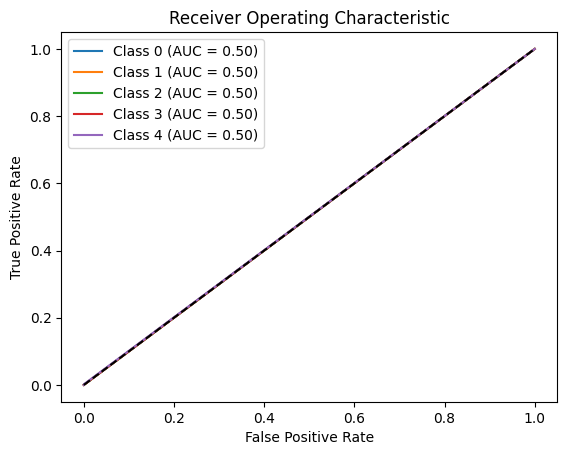

AUC of ROC: [0.5, 0.5, 0.5, 0.5, 0.5009356902076957]


In [13]:
# Function to calculate AUC of ROC
def calculate_roc_auc(model, dataloader):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)  # Apply softmax activation for multiclass classification
            scores = probabilities.cpu().numpy()  # Convert to NumPy array

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(scores)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    num_classes = len(np.unique(y_true))

    # Convert y_true to one-hot encoded form
    y_true_one_hot = label_binarize(y_true, classes=range(num_classes))

    # Compute ROC AUC for each class
    roc_aucs = []
    for class_idx in range(num_classes):
        class_true = y_true_one_hot[:, class_idx]
        class_scores = y_scores[:, class_idx]
        roc_auc = roc_auc_score(class_true, class_scores)
        roc_aucs.append(roc_auc)

        # Calculate and plot ROC curve
        fpr, tpr, _ = roc_curve(class_true, class_scores)
        plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

    return roc_aucs

# Calculate AUC of ROC and plot ROC curve
auc_total = calculate_roc_auc(model_ft, val_dataloader)
print('AUC of ROC:', auc_total)

In [14]:
def calculate_f1_score(model, dataloader, average=None):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x in dataloader:
            images = x[0].to(device)
            labels = x[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    f1 = f1_score(y_true, y_pred, average=average)
    return f1

# Calculate F1 scores for different average options
average_options = [None, 'micro', 'macro', 'weighted']
f1_scores = {}
for average in average_options:
    f1_scores[average] = calculate_f1_score(model_ft, val_dataloader, average=average)

# Print the F1 scores
for average, f1 in f1_scores.items():
    f1_mean = np.mean(f1)  # Calculate the mean of the F1 score array
    print('F1 Score ({}) : {:.4f}'.format(average, f1_mean))

F1 Score (None) : 0.1689
F1 Score (micro) : 0.7309
F1 Score (macro) : 0.1689
F1 Score (weighted) : 0.6173


In [15]:
def calculate_sensitivity_specificity(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x in dataloader:
            images = x[0].to(device)
            labels = x[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    # Extract values from the confusion matrix based on its shape
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (2,):
        tn, fp = cm.ravel()
        fn = tp =   
    else:
        tn = fp = fn = tp = 0

    # Handle zero division error
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return sensitivity, specificity

# Calculate Sensitivity and Specificity
sensitivity, specificity = calculate_sensitivity_specificity(model_ft, val_dataloader)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)

Sensitivity: 0
Specificity: 0


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

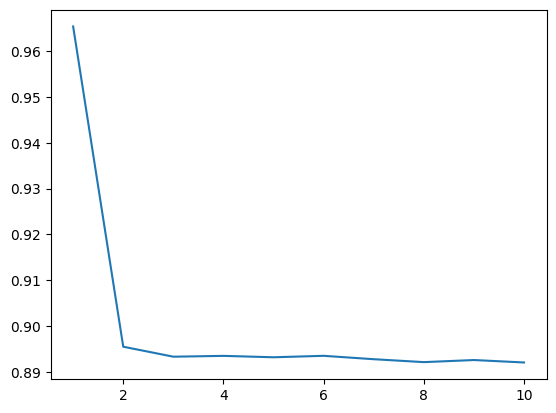

In [16]:
# Function to plot the validation curve
def plot_validation_curve(train_losses, val_losses):

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Curve')
    plt.legend()
    plt.show()
    
# Plot the Validation Curve
plot_validation_curve(train_losses, val_losses)

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

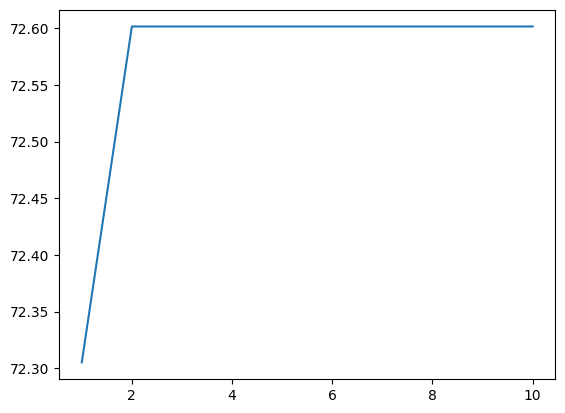

In [17]:
# Function to plot the learning curve
def plot_learning_curve(train_accs, val_accs):
    plt.plot(range(1, num_epochs + 1), train_accs, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()
    
# Plot the Learning Curve
plot_learning_curve(train_accs, val_accs)

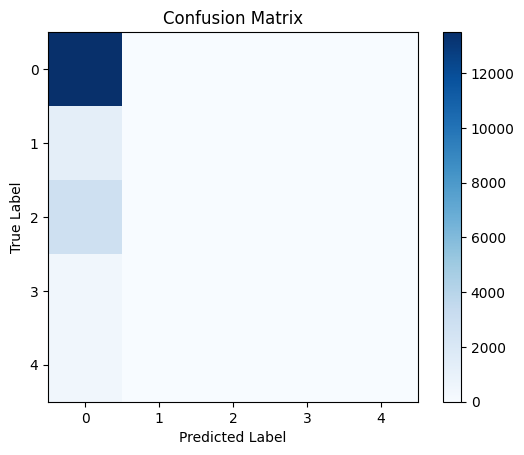

In [18]:
# Function to plot the confusion matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x in dataloader:
            images = x[0].to(device)
            labels = x[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
# Plot the Confusion Matrix
plot_confusion_matrix(model_ft, val_dataloader)